# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime as dt

# Parameters

In [2]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/dev.txt'
TEST_PATH = 'data/test-submit.txt'
EMBEDDINGS_PATH = 'embeddings/glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
BATCH_SIZE = 64
EPOCHS =20

# Load data

In [3]:
def load_embedding_dict(vec_path):
    embeddings_index = dict()
    with open(vec_path, 'r', encoding='UTF-8') as file:
        for line in tqdm(file.readlines()):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index
glove = load_embedding_dict(EMBEDDINGS_PATH)

100%|██████████████████████████████| 1193514/1193514 [00:31<00:00, 37900.07it/s]


In [4]:
for word, key in zip(glove.keys(),glove.values()):
    if key.shape!= (200,):
        print(word)
        to_be_pop = word
glove.pop(to_be_pop)

-0.29736


array([-0.57305  , -0.39627  ,  0.11851  ,  0.16625  ,  0.20137  ,
        0.15891  ,  0.27938  , -0.078399 , -0.12866  ,  0.21086  ,
        0.10652  , -0.45356  , -0.60928  , -0.44878  , -0.10511  ,
        0.32838  , -0.088057 ,  0.051537 ,  0.46852  , -0.13936  ,
       -0.71007  , -0.65363  ,  0.23445  , -0.19538  ,  0.6608   ,
        0.1313   , -0.045464 ,  0.43522  , -0.96466  ,  0.18855  ,
        0.93414  ,  0.68161  , -0.64802  ,  0.059672 , -0.69549  ,
       -0.31669  , -0.48399  , -0.63895  , -0.35644  ,  0.14326  ,
        0.79823  ,  0.41653  , -0.10187  ,  0.17715  , -0.20817  ,
       -0.47895  ,  0.36954  ,  0.4828   ,  0.37621  , -0.3492   ,
       -0.089045 ,  0.40169  , -0.8378   ,  0.19303  , -0.16941  ,
        0.2664   ,  0.49512  , -0.20796  ,  0.69913  ,  0.43428  ,
        0.15835  ,  0.38629  ,  0.24039  ,  0.031994 , -0.14381  ,
        0.52596  ,  0.28369  , -0.27033  ,  0.22807  ,  0.23541  ,
       -0.39603  , -0.31054  , -0.78715  , -0.71227  , -0.0292

In [5]:
'''
<user>
<repeat>
<hashtag>
<number>
<url>
<allcaps>
<elong>
'''
glove["<number>"]

array([ 3.4141e-01, -3.4142e-02,  1.6430e-01, -1.1149e-01,  1.4907e-01,
        5.2641e-01, -5.5042e-01,  3.5677e-01,  7.6170e-02,  4.8959e-01,
        1.0042e-01,  1.1230e-02, -2.4007e-02,  4.5353e-01, -6.1272e-01,
       -3.6067e-01,  8.1092e-02,  5.3523e-02, -5.0394e-01, -2.9240e-01,
       -5.7961e-01, -1.0894e-01,  3.2228e-01, -6.6214e-01,  7.6865e-01,
       -9.1760e-01, -4.0324e-01, -4.0874e-01,  4.7189e-01,  4.5127e-01,
       -7.4173e-01, -2.5656e-01, -3.0706e-02,  4.2865e-01,  1.1332e-01,
        3.0713e-01, -5.9145e-01, -1.7659e-01, -2.7424e-01, -3.0740e-01,
       -1.5549e+00, -3.1463e-02, -4.5362e-01,  2.1363e-01,  6.0165e-02,
       -9.3882e-01, -1.0469e-01, -9.5571e-01,  2.5844e-02, -3.5980e-01,
       -9.9932e-01, -6.4337e-01, -7.5182e-02,  3.9789e-01,  3.9114e-01,
        6.0404e-01, -2.3148e-01, -2.5137e-01,  1.2141e-01,  5.5073e-01,
        1.0099e-01, -8.1369e-01, -2.6309e-01, -4.7742e-01, -2.9244e-01,
        2.2078e-01,  1.3067e-01, -5.6455e-01,  2.8965e-01, -5.07

In [6]:
def clean_text(word):
    word = word.lower()
    word = re.sub("http\S+|www\S+", "<url>", word)
    word = re.sub("@\S+", "<user>", word)
    word = re.sub("#\S+", "<hashtag>", word)
    #word = re.sub("^[0-9]+$","<number>",word)
    return word

In [7]:
def read_data_from_txt(path):
    sentences = []
    sentence = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if line !="\n":
                splitted = line.split()
                word = splitted[0]
                entity = splitted[-1]
                word = clean_text(word)
                sentence.append((word, entity))
            else:
                sentences.append(sentence)
                sentence = []
        return sentences
    
def read_test_data_from_txt(path):
    sentences = []
    sentence = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if line !="\n":
                splitted = line.split()
                word = splitted[0]
                entity = None
                word = clean_text(word)
                sentence.append((word, entity))
            else:
                sentences.append(sentence)
                sentence = []
        return sentences

In [8]:
train_sentences = read_data_from_txt(TRAIN_PATH)
val_sentences = read_data_from_txt(DEV_PATH)
test_sentences = read_test_data_from_txt(TEST_PATH) 

In [9]:
print(len(train_sentences))

2394


In [10]:
max_len = 0 
for sen in val_sentences:
    length = len(sen)
    if length >= max_len:
        max_len = length
for sen in train_sentences:
    length = len(sen)
    if length >= max_len:
        max_len = length
print(f"sentence max length: {max_len}")

sentence max length: 41


# Indexer(word or tag <--> index)

In [11]:
class Indexer:
    def __init__(self, elements, index):
        if index:  # word_dict
            self._element_to_index = {"<PAD>": 0, "<UNK>": 1}
        else:      # tag_dict
            self._element_to_index = {"<PAD LABEL>":0}
        for x in elements:
            if x not in self._element_to_index:
                self._element_to_index[x] = len(self._element_to_index)

        self._index_to_element = {v: k for k,v in self._element_to_index.items()}

    def get_element_to_index_dict(self):
        return self._element_to_index

    def element_to_index(self, element):
        return self._element_to_index.get(element, 0)

    def index_to_element(self, index):
        return self._index_to_element[index]

    def elements_to_index(self, elements):
        return [self.element_to_index(x) for x in elements]

    def indexes_to_elements(self, indexes):
        return [self.index_to_element(x) for x in indexes]

    def size(self):
        return len(self._element_to_index)

In [12]:
words = []
tags = [] 
for sentence in train_sentences:
    for word, tag in sentence:
        words.append(word)
        tags.append(tag)
for extra_word in glove.keys():
    words.append(extra_word)
words = list(set(words))

In [13]:
words_indexer = Indexer(words, True)
tags_indexer = Indexer(tags, False)

In [14]:
print(words_indexer.element_to_index("<PAD>"))
print(words_indexer.index_to_element(0))
print(words_indexer.size())

0
<PAD>
1194685


In [15]:
labels = [x for x in tags_indexer.get_element_to_index_dict().values()]
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

# Pad the sentence

In [16]:
# pad the sequence
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
def encode_sentence(sentences):
    X = []
    Y = []
    for sentence in sentences:
        encode_sentence1 = []
        encode_sentence2 = []
        for word,tag in sentence:
            # tags
            encode_sentence2.append(tags_indexer.element_to_index(tag))
            # words
            if word not in words_indexer.get_element_to_index_dict():
                encode_sentence1.append(words_indexer.element_to_index("<UNK>"))
            else:
                encode_sentence1.append(words_indexer.element_to_index(word))
        X.append(encode_sentence1)    
        Y.append(encode_sentence2)
        
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=words_indexer.element_to_index("<PAD>"))
    Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tags_indexer.element_to_index("<PAD LABEL>"))
    Y = [to_categorical(i, num_classes=tags_indexer.size()) for i in Y]
    return X, Y
train_X, train_Y = encode_sentence(train_sentences)
val_X, val_Y = encode_sentence(val_sentences)
test_X, _= encode_sentence(val_sentences)

2022-10-27 14:56:10.851178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 14:56:11.038782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 14:56:11.718361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2022-10-27 14:56:11.718426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: l

# Build word embedding

In [17]:
class Embedding:
    def initialization(matrix, unknown_vector, word_indexer, embedding_dict):
            for word, i in word_indexer.get_element_to_index_dict().items():
                vector = unknown_vector
                if word =="<PAD>":
                    vector = np.zeros(EMBEDDING_DIM)
                if word in embedding_dict.keys():
                    vector = embedding_dict[word]
                elif word.lower() in embedding_dict.keys():
                    vector = embedding_dict[word.lower()]
                matrix[i] = vector
            return matrix
    EMBEDDING_Parameter = {"parameters": lambda matrix, unknown_vector, word_indexer, embedding_dict: Embedding.initialization(matrix, unknown_vector, word_indexer, embedding_dict)}
    def get_embedding_layer(word_indexer, embedding_dict):
        
        matrix_len = word_indexer.size()
        embedding_dim = next(iter(embedding_dict.values())).shape[0]
        weights_matrix = np.zeros((matrix_len, embedding_dim))

        unknown_vector = np.random.randn(EMBEDDING_DIM)
        
        weights_matrix = Embedding.EMBEDDING_Parameter["parameters"](weights_matrix,
                                                                           unknown_vector,
                                                                           word_indexer,
                                                                           embedding_dict)

        embedding = nn.Embedding(matrix_len, embedding_dim)
        embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})

        return embedding

In [18]:
Embedding.get_embedding_layer(words_indexer, glove)(torch.tensor([0], dtype=torch.long))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<EmbeddingBackward0>)

# Model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = Embedding.get_embedding_layer(words_indexer, glove)
        
        self.word_embeddings.weight.requires_grad = False
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, bidirectional = True) 

        self.hidden2tag = nn.Linear(2*hidden_dim, tagset_size)
    
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # (32,41,100)
        embeds = self.dropout(embeds)
        lstm_out, _ = self.lstm(embeds)         # (sequence length, batch size, input size) when batch_first=False
        tag_space = self.hidden2tag(lstm_out.view(len(sentence),max_len, -1))
        return tag_space

In [20]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, tags_indexer.size())

In [21]:
def get_tag_indexes_from_scores(scores):
    import numpy as np
    predicted = []
    for sen in scores:
        pred_word = []
        for word in sen:
            pred_word.append(int(np.argmax(word)))
        predicted.append(pred_word)
    return predicted        

with torch.no_grad():
    sentence_in = torch.tensor(train_X[0:2], dtype=torch.long)
    print("Input")
    print(sentence_in.shape)
    print(sentence_in)
    tag_scores = model(sentence_in)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(tag_scores.transpose(1,2),torch.tensor(train_Y[0:2], dtype=torch.float32).transpose(1,2))
    output = get_tag_indexes_from_scores(torch.tensor(train_Y[0:2], dtype=torch.float32).detach().numpy())
    output = torch.tensor(output, dtype=torch.long)
    print("Output")
    print(output.shape)
    print(output)

Input
torch.Size([2, 41])
tensor([[ 212710,  212710,  806543,  951973,  767858,  472011, 1136777,  347193,
          109090,  574595,  201439,  803829,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0],
        [ 989075,  571442, 1096391,  270009,  715636,  832717,  929743,  571442,
         1050204,    4571,  715636,  767858,  587661, 1189608,   73175,  423623,
          426048,  295802,  547141,  715636,  767858,  270009,  929743,  126925,
          715636,  753330,  901036,  134816,  373569, 1189608,   73175,   87907,
          929743,       0,       0,       0,       0,       0,       0,       0,
               0]])
Output
torch.Size([2, 41])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

/tmp/ipykernel_93880/1076164844.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  loss = loss_function(tag_scores.transpose(1,2),torch.tensor(train_Y[0:2], dtype=torch.float32).transpose(1,2))


# Training

In [22]:
def save_model():
    filename = f"model/LSTMTagger-{dt.now().strftime('%Y-%m-%d-%H-%M-%S')}.pkl"
    best_state_dict = model.state_dict()
    torch.save(best_state_dict, filename)
    print(f"save model at: {filename}")

In [23]:
def get_batched(words, labels, size):
    for i in range(0, len(words), size):
        yield (words[i:i + size], labels[i:i + size])

def train_model(model, optimizer, loss_function, batch_size, word_indexer, tag_indexer, num_epochs=EPOCHS): 
    
    losses = []
    val_losses = []
    accuracys = []
    val_accuracys = []
    batches = list(get_batched(train_X, train_Y, batch_size))
    
    for epoch in range(num_epochs):
        
        correct_predictions = 0
        val_correct_predictions = 0
        running_loss = 0.0
        total = 0
        val_total = 0
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('=' * 40)
        # train
        for sentences, tags in tqdm(batches):
            model.train()
            optimizer.zero_grad()
            sentence_in = torch.tensor(sentences, dtype=torch.long)
            targets = torch.tensor(tags, dtype=torch.float32)
            tag_scores = model(sentence_in)
            # loss
            loss = loss_function(tag_scores.transpose(1,2), targets.transpose(1,2))
            running_loss += loss.item() * sentence_in.size(0)
            loss.backward()
            optimizer.step()
            # accuracy
            prediction = torch.tensor(get_tag_indexes_from_scores(tag_scores.detach().numpy()), dtype=torch.long)
            label = torch.tensor(get_tag_indexes_from_scores(targets.detach().numpy()), dtype=torch.long)
            correct_predictions += torch.sum(prediction == label)
            total += torch.sum(prediction == prediction)
        # evalution
        with torch.no_grad(): 
            model.eval()
            inputs = torch.tensor(val_X, dtype=torch.long)
            val_targets = torch.tensor(val_Y, dtype=torch.float32)
            val_tag_scores = model(inputs)
            val_epoch_loss = loss_function(val_tag_scores.transpose(1,2), val_targets.transpose(1,2))
            val_prediction = torch.tensor(get_tag_indexes_from_scores(val_tag_scores.detach().numpy()), dtype=torch.long)
            val_label = torch.tensor(get_tag_indexes_from_scores(val_targets.detach().numpy()), dtype=torch.long)
            val_correct_predictions += torch.sum(val_prediction == val_label)
            val_total += torch.sum(val_prediction == val_prediction)
            
        accuracy = correct_predictions / total
        val_accuracy = val_correct_predictions / val_total
        epoch_loss = running_loss / (len(batches)*max_len)
        losses.append(epoch_loss)    
        val_losses.append(val_epoch_loss)
        accuracys.append(accuracy)
        val_accuracys.append(val_accuracy)
        print(f'[train accuracy]: {accuracy}')    
        print(f"Loss per epoch - {epoch_loss}")
        print("-----------------------------------")
        print(f'[test accuracy]: {val_accuracy}')
        print(f"Loss per epoch - {val_epoch_loss}")   
        
    return model, losses, val_losses, accuracys, val_accuracys

In [24]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
history = train_model(model,
                      optimizer,
                      loss_function, 
                      BATCH_SIZE, 
                      words_indexer, 
                      tags_indexer,  
                      num_epochs=EPOCHS)
#save_model()

Epoch 1/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.40it/s]


[train accuracy]: 0.7989282011985779
Loss per epoch - 1.287949312712629
-----------------------------------
[test accuracy]: 0.8862195014953613
Loss per epoch - 0.40224331617355347
Epoch 2/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.37it/s]


[train accuracy]: 0.9340423941612244
Loss per epoch - 0.4370189312563322
-----------------------------------
[test accuracy]: 0.9561463594436646
Loss per epoch - 0.22564741969108582
Epoch 3/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.59it/s]


[train accuracy]: 0.9675509929656982
Loss per epoch - 0.2875040738014875
-----------------------------------
[test accuracy]: 0.966560959815979
Loss per epoch - 0.18849268555641174
Epoch 4/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.55it/s]


[train accuracy]: 0.9710862636566162
Loss per epoch - 0.2565504433216577
-----------------------------------
[test accuracy]: 0.9689024686813354
Loss per epoch - 0.17427471280097961
Epoch 5/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.62it/s]


[train accuracy]: 0.9733684062957764
Loss per epoch - 0.22992902952073016
-----------------------------------
[test accuracy]: 0.9696097373962402
Loss per epoch - 0.1620357185602188
Epoch 6/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.47it/s]


[train accuracy]: 0.974264919757843
Loss per epoch - 0.21025747187024363
-----------------------------------
[test accuracy]: 0.9710975885391235
Loss per epoch - 0.15335413813591003
Epoch 7/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.49it/s]


[train accuracy]: 0.9753448367118835
Loss per epoch - 0.1978121303758358
-----------------------------------
[test accuracy]: 0.9716097712516785
Loss per epoch - 0.14714831113815308
Epoch 8/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.46it/s]


[train accuracy]: 0.9766082167625427
Loss per epoch - 0.18717102457760845
-----------------------------------
[test accuracy]: 0.9731951355934143
Loss per epoch - 0.14296923577785492
Epoch 9/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.54it/s]


[train accuracy]: 0.9769545793533325
Loss per epoch - 0.18286281348766809
-----------------------------------
[test accuracy]: 0.9732927083969116
Loss per epoch - 0.14104098081588745
Epoch 10/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.36it/s]


[train accuracy]: 0.9772194623947144
Loss per epoch - 0.17842126667346514
-----------------------------------
[test accuracy]: 0.973878026008606
Loss per epoch - 0.13976171612739563
Epoch 11/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.58it/s]


[train accuracy]: 0.977463960647583
Loss per epoch - 0.1746368649797048
-----------------------------------
[test accuracy]: 0.9736829400062561
Loss per epoch - 0.13934394717216492
Epoch 12/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.46it/s]


[train accuracy]: 0.9777899980545044
Loss per epoch - 0.17121271090880896
-----------------------------------
[test accuracy]: 0.9737073183059692
Loss per epoch - 0.1389176994562149
Epoch 13/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.59it/s]


[train accuracy]: 0.9784623980522156
Loss per epoch - 0.16745474761464324
-----------------------------------
[test accuracy]: 0.9744146466255188
Loss per epoch - 0.13544243574142456
Epoch 14/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.54it/s]


[train accuracy]: 0.9789208769798279
Loss per epoch - 0.1627323053518982
-----------------------------------
[test accuracy]: 0.9745122194290161
Loss per epoch - 0.13524675369262695
Epoch 15/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.58it/s]


[train accuracy]: 0.9793691635131836
Loss per epoch - 0.15822298680366387
-----------------------------------
[test accuracy]: 0.9748048782348633
Loss per epoch - 0.13365936279296875
Epoch 16/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.44it/s]


[train accuracy]: 0.979695200920105
Loss per epoch - 0.15388282156992938
-----------------------------------
[test accuracy]: 0.9743902683258057
Loss per epoch - 0.13364258408546448
Epoch 17/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.60it/s]


[train accuracy]: 0.980347216129303
Loss per epoch - 0.14853175620480283
-----------------------------------
[test accuracy]: 0.9748048782348633
Loss per epoch - 0.1327984631061554
Epoch 18/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.41it/s]


[train accuracy]: 0.9806120991706848
Loss per epoch - 0.14387940702450597
-----------------------------------
[test accuracy]: 0.9745609760284424
Loss per epoch - 0.13398140668869019
Epoch 19/20


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.61it/s]


[train accuracy]: 0.9809686541557312
Loss per epoch - 0.1416764447563573
-----------------------------------
[test accuracy]: 0.9749024510383606
Loss per epoch - 0.1352238655090332
Epoch 20/20


100%|███████████████████████████████████████████| 38/38 [00:11<00:00,  3.39it/s]


[train accuracy]: 0.9811928272247314
Loss per epoch - 0.13600201290746403
-----------------------------------
[test accuracy]: 0.9750000238418579
Loss per epoch - 0.13527095317840576


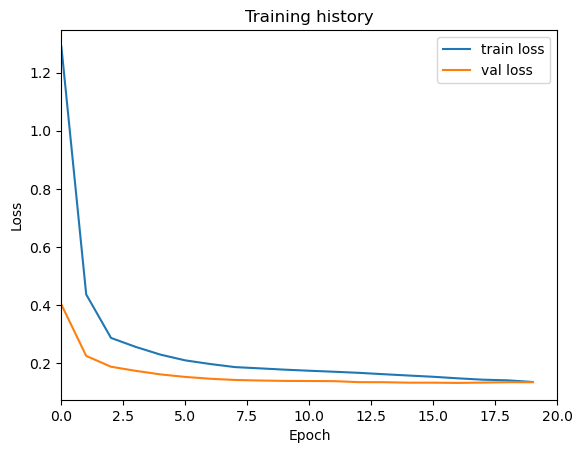

In [25]:
epochs = [i for i in range(EPOCHS)]
plt.plot(epochs, history[1], label='train loss')
plt.plot(epochs, history[2], label='val loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xlim([0, EPOCHS])
plt.show()

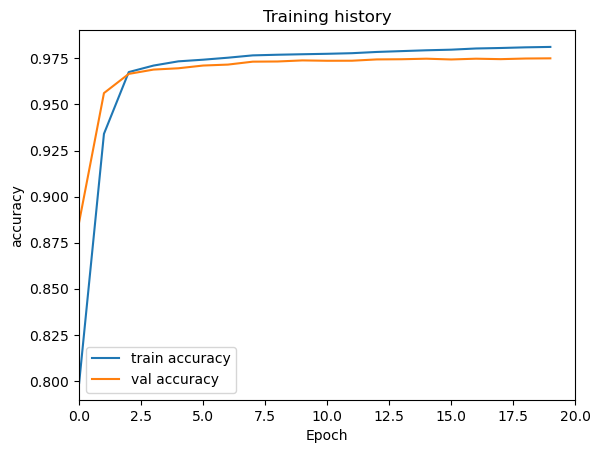

In [26]:
plt.plot(epochs, history[3], label='train accuracy')
plt.plot(epochs, history[4], label='val accuracy')
plt.title('Training history')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.xlim([0, EPOCHS])
plt.show()

# Evaluation

In [27]:
def prediction(data, true_tags, test):
    inputs = torch.tensor(data ,dtype=torch.long)
    tag_scores = model(inputs)
    idx = get_tag_indexes_from_scores(tag_scores.detach().numpy())
    origin = [words_indexer.indexes_to_elements(index_list) for index_list in data]
    tags_list = [tags_indexer.indexes_to_elements(index_list) for index_list in idx]
    origin_word = []
    pred_list = []
    if test:    
        for sentence, tags in zip(origin, tags_list):
            for word, tag in zip(sentence, tags):
                if word != "<PAD>":
                    origin_word.append(word)
                    if tag !="<PAD LABEL>":
                        pred_list.append(tag)
                    else: 
                        pred_list.append("O")
        return origin_word, pred_list
    
    else:
        origin_label = []
        for sentence,trues, tags in zip(origin, true_tags, tags_list):
            for word, true, tag in zip(sentence, trues, tags):
                if word != "<PAD>":
                    origin_word.append(word)
                    origin_label.append(tags_indexer.index_to_element(np.argmax(true)))
                    if tag !="<PAD LABEL>":
                        pred_list.append(tag)
                    else: 
                        pred_list.append("O")
        return origin_word, pred_list, origin_label


In [28]:
import pandas as pd
display_words, display_tags, dispaly_true = prediction([val_X[0]],[val_Y[0]], False)
display = pd.DataFrame({"Word" : display_words,"True" : dispaly_true, "Prediction" : display_tags})
display

,Word,True,Prediction
0,stop,O,O
1,what,O,O
2,you're,O,O
3,doing,O,O
4,and,O,O
5,go,O,O
6,get,O,O
7,<hashtag>,O,O
8,on,O,O
9,itunes,B-other,O


# Write file

In [29]:
test_words, test_tags = prediction(test_X, None, True)
dev_words, dev_preds, dev_true = prediction(val_X, val_Y, False)

In [30]:
path = 'sol_submit_7.txt'
f = open(path, 'w')
for word,tag in zip(test_words, test_tags):
    f.write(word+" "+tag+"\n")
f.close()

In [31]:
path = 'sol_dev_accuracy_7.txt'
f = open(path, 'w')
for word, tag, pred in zip(dev_words, dev_true, dev_preds):
    f.write(word+" "+tag+" "+pred+"\n")
f.close()

# Testing accuracy

In [33]:
!python conlleval.py < sol_dev_accuracy_3.txt 
print()
!python conlleval.py < sol_dev_accuracy_7.txt

processed 16261 tokens with 661 phrases; found: 525 phrases; correct: 140.
accuracy:  18.44%; (non-O)
accuracy:  93.57%; precision:  26.67%; recall:  21.18%; FB1:  23.61
          company: precision:  58.33%; recall:  17.95%; FB1:  27.45  12
         facility: precision:  10.00%; recall:   2.63%; FB1:   4.17  10
          geo-loc: precision:  31.18%; recall:  50.00%; FB1:  38.41  186
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            other: precision:  12.99%; recall:   7.58%; FB1:   9.57  77
           person: precision:  27.39%; recall:  36.84%; FB1:  31.42  230
          product: precision:  10.00%; recall:   2.70%; FB1:   4.26  10
       sportsteam: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  0

processed 16261 tokens with 661 phrases; found: 399 phrases; correct: 109.
accuracy:  15.07%; (non-O)
accuracy: